# Practice notebook for univariate analysis using NHANES data

This notebook will give you the opportunity to perform some univariate analyses on your own using the NHANES.  These analyses are similar to what was done in the week 2 NHANES case study notebook.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
import numpy as np

da = pd.read_csv("nhanes_2015_2016.csv")

## Question 1

Relabel the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to have brief but informative character labels.  Then construct a frequency table of these values for all people, then for women only, and for men only.  Then construct these three frequency tables using only people whose age is between 30 and 40.

In [2]:
da.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [3]:
data = da.rename(columns = {'DMDMARTL': 'MaritalStatus', 'RIAGENDR': "Gender", 'RIDAGEYR' : "Age" })

In [4]:
data.groupby('Gender')['Gender'].agg('count')

Gender
1    2759
2    2976
Name: Gender, dtype: int64

In [5]:
data['MaritalStatus'] = data.MaritalStatus.replace({1.0 : 'Married',
                             2.0 : 'Widowed',
                             3.0 : 'Divorced',
                             4.0 : 'Separated',
                             5.0 : 'Never married',
                             6.0 : 'Living with partner',
                             77.0 : 'Refused',
                             99.0 : "Don't know"})
data['Gender'] = data.Gender.replace({1 : 'Male', 2 : 'Female'})                  

In [6]:
MSGender = data.groupby(['Gender','MaritalStatus'])['MaritalStatus'].agg('count').unstack()
MS = data.groupby(['MaritalStatus'])['MaritalStatus'].agg('count')
MSGender

MaritalStatus,Divorced,Living with partner,Married,Never married,Refused,Separated,Widowed
Gender,,,,,,,
Female,350,262,1303,520,1,118,296
Male,229,265,1477,484,1,68,100


In [7]:
MSGender.sum(axis=1)

Gender
Female    2850
Male      2624
dtype: int64

I've got a NaN for 77.0 when I counted the groups. So I eliminated it.

In [8]:
#ages between 30 and 40's - slicing
table3 = data.loc[(data.Age >= 30) & (data.Age <=40)]
#~ reverses the logical statement, gives a False where is True, and eliminates rows with Refused (Nan where for Females)
table3 = table3.loc[~table3.MaritalStatus.isin(['Refused']), :]
MS30_40 = table3.groupby(['Gender','MaritalStatus'])['MaritalStatus'].agg('count').unstack()
MS30_40

MaritalStatus,Divorced,Living with partner,Married,Never married,Separated,Widowed
Gender,,,,,,
Female,46,65,285,116,18,2
Male,24,78,275,101,12,3


__Q1a.__ Briefly comment on some of the differences that you observe between the distribution of marital status between women and men, for people of all ages.

There are more female individuals than male, but female are more frequent in any case but 'Married' or 'Living with partner'. To analyze our data more accurately, it's better to look ak the percentages and plot it.

In [9]:
MSGenderSplt = pd.DataFrame(MSGender.stack())
MSGenderSplt.reset_index(inplace=True)
MSGenderSplt = MSGenderSplt.rename(columns = {0: "Count"})

In [10]:
totalfemale = MSGenderSplt.loc[MSGenderSplt['Gender'] == 'Female'].Count.sum()
totalmale = MSGenderSplt.loc[MSGenderSplt['Gender'] == 'Male'].Count.sum()
supportlist = list()

for i in MSGenderSplt.index:
    if MSGenderSplt.iloc[i,0] == "Female":
        supportlist.append(MSGenderSplt.iloc[i,2]/totalfemale)
    else:
        supportlist.append(MSGenderSplt.iloc[i,2] / totalmale)
        
MSGenderSplt['RelativePercent'] = pd.Series(supportlist)
MSGenderSplt.groupby('Gender')['RelativePercent'].agg('sum')
MSGenderSplt

,Gender,MaritalStatus,Count,RelativePercent
0,Female,Divorced,350,0.122807
1,Female,Living with partner,262,0.091930
2,Female,Married,1303,0.457193
3,Female,Never married,520,0.182456
4,Female,Refused,1,0.000351
5,Female,Separated,118,0.041404
6,Female,Widowed,296,0.103860
7,Male,Divorced,229,0.087271
8,Male,Living with partner,265,0.100991
9,Male,Married,1477,0.562881


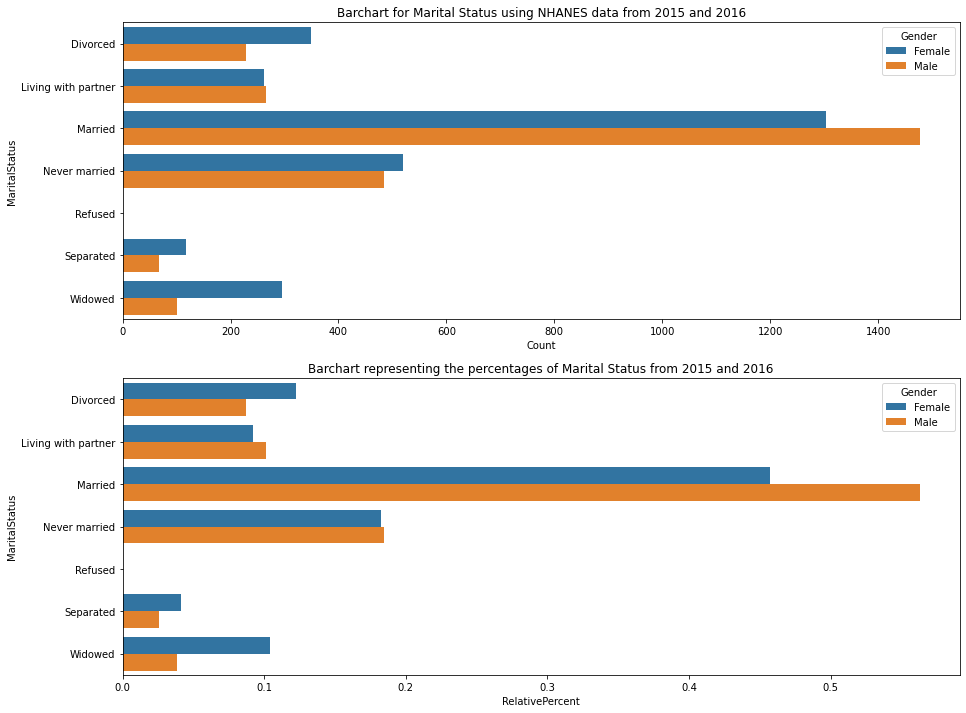

<Figure size 1080x504 with 0 Axes>

In [11]:
f, (ax1,ax2) = plt.subplots(2,1, figsize = (15,12))

sns.barplot(y = MSGenderSplt.MaritalStatus,
            x = 'Count',
            hue = 'Gender', data = MSGenderSplt, ax = ax1)
ax1.set_title("Barchart for Marital Status using NHANES data from 2015 and 2016")

plt.figure(figsize = (15,7))
sns.barplot(y = MSGenderSplt.MaritalStatus,
            x = 'RelativePercent',
            hue = 'Gender', data = MSGenderSplt, ax = ax2)
ax2.set_title("Barchart representing the percentages of Marital Status from 2015 and 2016")

plt.tight_layout(pad = 2.0)
plt.show()

From the graphs above we can see that the percentages are more efficient to judge the differences in Marital Status between women and men, since the total of individuals is different. We can realize that there are more divorced and widowed females, while marriage is more common at the male population.

__Q1b.__ Briefly comment on the differences that you observe between the distribution of marital status states for women between the overall population, and for women between the ages of 30 and 40.

In [12]:
MS30_40s = pd.DataFrame(MS30_40.stack())
MS30_40s.reset_index(inplace = True)
MS30_40s = MS30_40s.rename(columns = {0:'Counts'})
MSwomen30_40 = MS30_40s.loc[MS30_40s.Gender == "Female"]
MSmale30_40 = MS30_40s.loc[MS30_40s.Gender == "Male"]

In [14]:
MSwomen30_40['RelativePercent'] = MSwomen30_40.apply(lambda x: (x['Counts']/sum(MSwomen30_40.Counts)), axis = 1)
MSwomen30_40['Age'] = ('30 to 40')

<ipython-input-14-a2b5fb6eae1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSwomen30_40['RelativePercent'] = MSwomen30_40.apply(lambda x: (x['Counts']/sum(MSwomen30_40.Counts)), axis = 1)
<ipython-input-14-a2b5fb6eae1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSwomen30_40['Age'] = ('30 to 40')


In [15]:
MSGenders = pd.DataFrame(MSGender.stack())
MSGenders.reset_index(inplace = True)
MSGenders = MSGenders.rename(columns = {0:'Counts'})
MSwomenGenders = MSGenders.loc[MSGenders.Gender == "Female"]
MSwomenGenders['RelativePercent'] = MSwomenGenders.apply(lambda x: (x['Counts']/sum(MSwomenGenders.Counts)), axis = 1)
MSwomenGenders['Age'] = ("Adult")

<ipython-input-15-7eb3425a2aba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSwomenGenders['RelativePercent'] = MSwomenGenders.apply(lambda x: (x['Counts']/sum(MSwomenGenders.Counts)), axis = 1)
<ipython-input-15-7eb3425a2aba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSwomenGenders['Age'] = ("Adult")


In [16]:
MSwomenjoined = pd.concat([MSwomenGenders, MSwomen30_40],ignore_index=True)
MSwomenjoined

,Gender,MaritalStatus,Counts,RelativePercent,Age
0,Female,Divorced,350,0.122807,Adult
1,Female,Living with partner,262,0.091930,Adult
2,Female,Married,1303,0.457193,Adult
3,Female,Never married,520,0.182456,Adult
4,Female,Refused,1,0.000351,Adult
5,Female,Separated,118,0.041404,Adult
6,Female,Widowed,296,0.103860,Adult
7,Female,Divorced,46,0.086466,30 to 40
8,Female,Living with partner,65,0.122180,30 to 40
9,Female,Married,285,0.535714,30 to 40


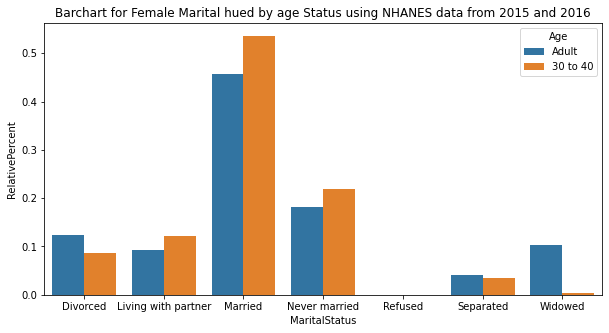

In [17]:
f, (ax1) = plt.subplots(figsize = (10,5))

sns.barplot(x = MSwomenjoined.MaritalStatus,
            y = 'RelativePercent',
            hue = 'Age', data = MSwomenjoined, ax = ax1)
ax1.set_title("Barchart for Female Marital hued by age Status using NHANES data from 2015 and 2016")
plt.show()

__Q1c.__ Repeat part b for the men.

<ipython-input-18-702aa77fdfad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSmale30_40['RelativePercent'] = MSmale30_40.apply(lambda x: (x['Counts']/sum(MSmale30_40.Counts)), axis = 1)
<ipython-input-18-702aa77fdfad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSmale30_40['Age'] = ('30 to 40')
<ipython-input-18-702aa77fdfad>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

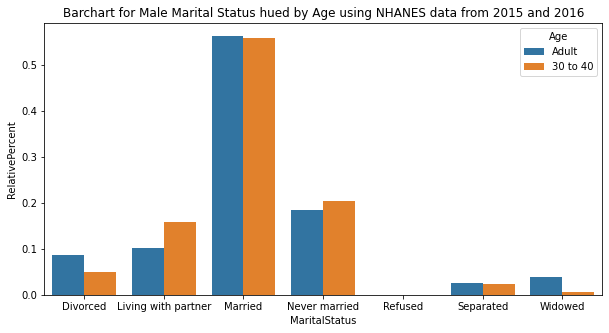

In [18]:
MSmale30_40['RelativePercent'] = MSmale30_40.apply(lambda x: (x['Counts']/sum(MSmale30_40.Counts)), axis = 1)
MSmale30_40['Age'] = ('30 to 40')

MSGenders = pd.DataFrame(MSGender.stack())
MSGenders.reset_index(inplace = True)
MSGenders = MSGenders.rename(columns = {0:'Counts'})
MSmaleGenders = MSGenders.loc[MSGenders.Gender == "Male"]
MSmaleGenders['RelativePercent'] = MSmaleGenders.apply(lambda x: (x['Counts']/sum(MSmaleGenders.Counts)), axis = 1)
MSmaleGenders['Age'] = ("Adult")

MSmalejoined = pd.concat([MSmaleGenders, MSmale30_40],ignore_index=True)


f, (ax1) = plt.subplots(figsize = (10,5))

sns.barplot(x = MSmalejoined.MaritalStatus,
            y = 'RelativePercent',
            hue = 'Age', data = MSmalejoined, ax = ax1)
ax1.set_title("Barchart for Male Marital Status hued by Age using NHANES data from 2015 and 2016")
plt.show()

Younger Men, on the other hand, tend to live with parter or be single. While elder the number of divorced or widowed elder men is greater.

#### Conclusion of the first exercise. It would be better to read the whole exercise and set a table that could be sliced to generate graphs :)

I created almost 10 different dataframes and applied lambda almost 5 times. I could do it once if I had created a table at the beginning :) 

Plan first, do later!

## Question 2

Restricting to the female population, stratify the subjects into age bands no wider than ten years, and construct the distribution of marital status within each age band.  Within each age band, present the distribution in terms of proportions that must sum to 1.

__Q2a.__ Comment on the trends that you see in this series of marginal distributions.

[Labeling axis ticks](https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib)

In [152]:
data['Agex'] = pd.cut(x = data.Age,
                    bins = [17,30,40,50,60,70,80],
                    labels = ['18 to 30','31 to 40', '41 to 50', '51 to 60', '61 to 70', '71 to 80']) 

In [157]:
#Gender, Agex, MaritalStatus, and count values of marital
df2 = pd.DataFrame(data.groupby(['Gender','Agex'])['MaritalStatus'].value_counts())
df2 = df2.rename(columns = {"MaritalStatus": 'Counts'})
df2.reset_index(inplace = True)
df2['Gender'] = df2['Gender'].replace({1:'Male', 2:'Female'})
#Lambda.
#everytime it changes the group, so does the reference to x.sum! Incredible function
df2Female = df2.loc[df2.Gender == 'Female']
df2Male = df2.loc[df2.Gender == 'Male']

In [159]:
df2Female

,Gender,Agex,MaritalStatus,Counts
37,Female,18 to 30,5.0,259
38,Female,18 to 30,1.0,158
39,Female,18 to 30,6.0,114
40,Female,18 to 30,3.0,11
41,Female,18 to 30,4.0,11
42,Female,31 to 40,1.0,258
43,Female,31 to 40,5.0,97
44,Female,31 to 40,6.0,57
45,Female,31 to 40,3.0,43
46,Female,31 to 40,4.0,17


In [20]:
df2Female['RelativePercent'] = df2Female.groupby('Agex')['Counts'].apply(lambda x: 100*x/x.sum())
df2Male['RelativePercent'] = df2Male.groupby('Agex')['Counts'].apply(lambda x: 100*x/x.sum())

<ipython-input-20-f02f66f36ffb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2Female['RelativePercent'] = df2Female.groupby('Agex')['Counts'].apply(lambda x: 100*x/x.sum())
<ipython-input-20-f02f66f36ffb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2Male['RelativePercent'] = df2Male.groupby('Agex')['Counts'].apply(lambda x: 100*x/x.sum())


Selecting male and female to new DataFrame

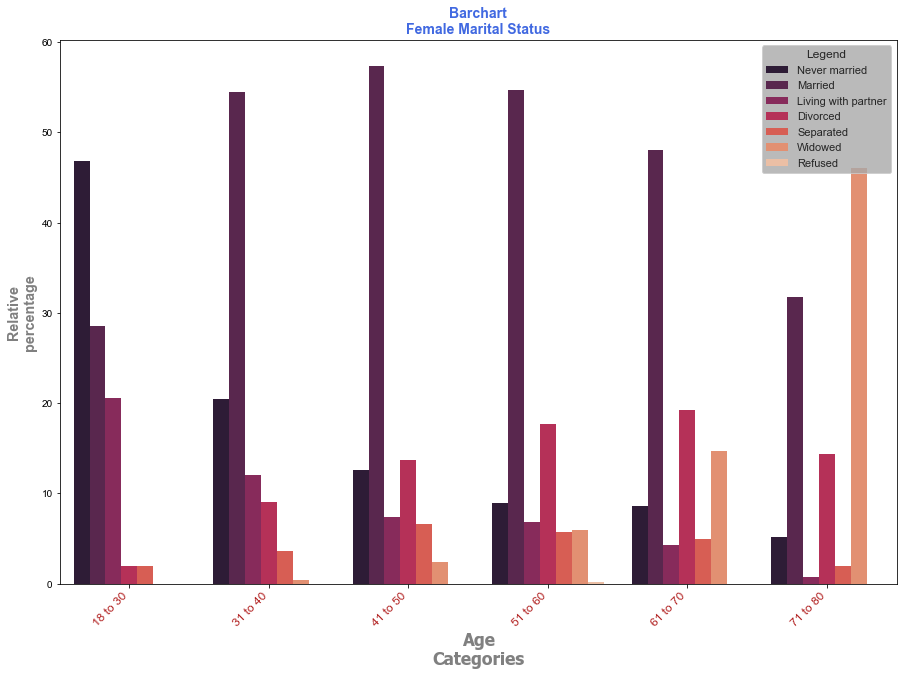

In [21]:
plt.figure(figsize=(15,10), edgecolor='white')
bargraphfemale = sns.barplot(x = 'Agex',
            y = 'RelativePercent',
            hue = 'MaritalStatus',
            palette = 'rocket',
            data = df2Female)
#plt.title('Barchart\nFemale Marital Status', weight="bold", fontsize=14)

#plt.text(15, -0.8, "Barchart\n", weight="bold", fontsize=14, ha='center')
#plt.text(15, -0.8, "Female Marital Status", ha='center')

sns.set(rc={'axes.facecolor': 'darkgray', 'figure.facecolor':'white'})
        
plt.legend(title = 'Legend',)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium', color= 'firebrick')
plt.ylabel('Relative\npercentage', fontweight = 'bold', fontsize = 'large', color= 'grey')
plt.xlabel('Age\nCategories', fontweight = 'bold', fontsize = 'x-large', color= 'grey', fontfamily = "tahoma")
plt.title("Barchart\nFemale Marital Status", weight="bold", fontsize=14, ha='center', color = 'RoyalBlue')


plt.show()

'Never married' individuals are more frequente at the young women population. At higher ages, we can say that widowed women are predominant. At adulthood, on the other hand, the group of 'Married' women prevails, and the proportion of divorced increase.


__Q2b.__ Repeat the construction for males.

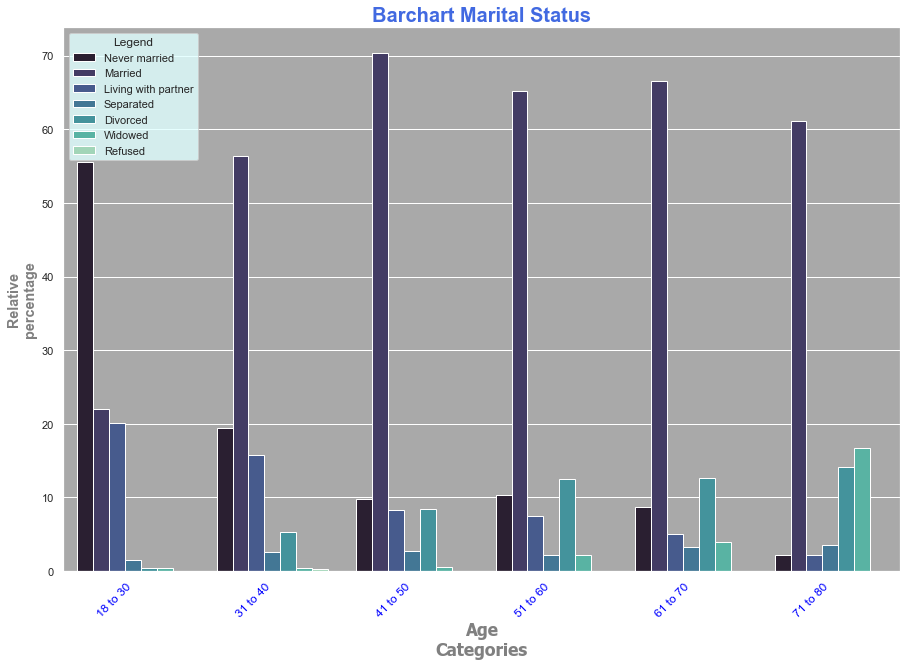

In [22]:
plt.figure(figsize=(15,10), edgecolor='white')
bargraphmale = sns.barplot(x = 'Agex',
            y = 'RelativePercent',
            hue = 'MaritalStatus',
            palette = 'mako',
            data = df2Male)
#plt.title('Barchart\nFemale Marital Status', weight="bold", fontsize=14)

#plt.text(15, -0.8, "Barchart\n", weight="bold", fontsize=14, ha='center')
#plt.text(15, -0.8, "Female Marital Status", ha='center')

sns.set(rc={'axes.facecolor': 'lightcyan', 'figure.facecolor':'white'})
        
plt.legend(title = 'Legend')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium', color= 'blue')
plt.ylabel('Relative\npercentage', fontweight = 'bold', fontsize = 'large', color= 'grey')
plt.xlabel('Age\nCategories', fontweight = 'bold', fontsize = 'x-large', color= 'grey', fontfamily = "tahoma")
plt.title("Barchart Marital Status", weight="bold", fontsize=20, ha='center', color = 'RoyalBlue')
plt.show()

the percentage of never married is clearly predominant betweem young men. Married men proportion increase at older ages. It's worth noticing that divorced and widowed increase rightwards.

__Q2c.__ Comment on any notable differences that you see when comparing these results for females and for males.

[stacked and grouped barplot, but too rudimentar using matplotlib](https://gist.github.com/ctokheim/6435202a1a880cfecd71)

[PLOTLY IS THE BEST OPTION](https://plotly.com/python/bar-charts/)

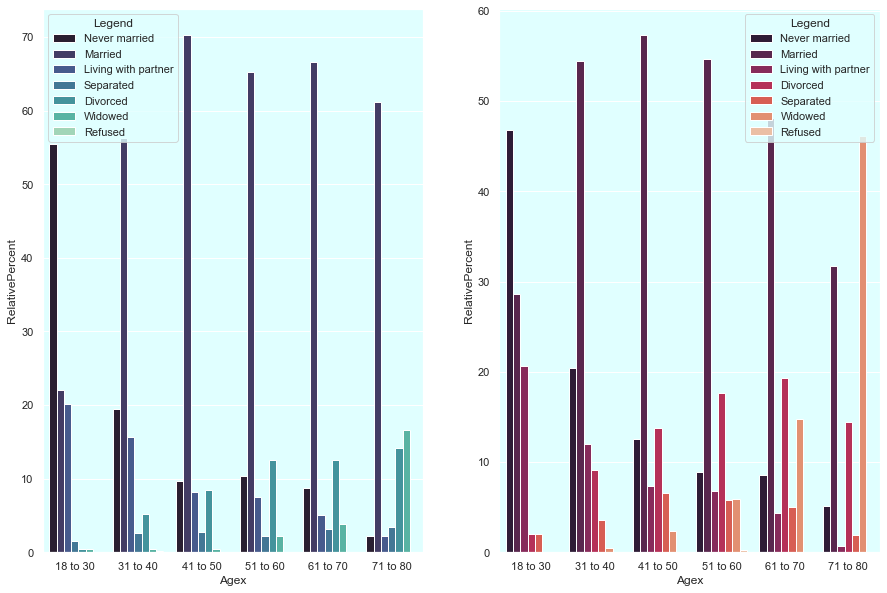

<Figure size 1080x720 with 0 Axes>

In [24]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10), edgecolor='white')
bargraphmale = sns.barplot(x = 'Agex',
            y = 'RelativePercent',
            hue = 'MaritalStatus',
            palette = 'mako',
            ax = ax1,
            data = df2Male)

sns.set(rc={'axes.facecolor': 'lightcyan', 'figure.facecolor':'white'})
        
ax1.legend(title = 'Legend')
plt.figure(figsize=(15,10), edgecolor='white')
bargraphfemale = sns.barplot(x = 'Agex',
            y = 'RelativePercent',
            hue = 'MaritalStatus',
            palette = 'rocket',
            ax = ax2,
            data = df2Female)
        
ax2.legend(title = 'Legend', loc ='upper right')

plt.show()

What changes most significantly is that widowed proportion is higher to elder women than to men. Desconsidering the married group, at the 50's and 60's, however, the proportion of divorced women increases. Men at the same age, if not married, tend to be widowed.

## Question 3

Construct a histogram of the distribution of heights using the BMXHT variable in the NHANES sample.

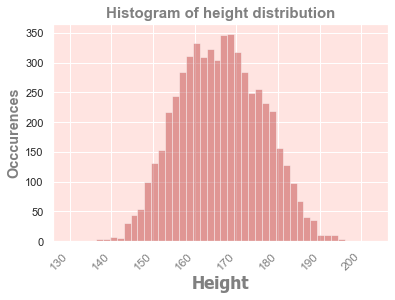

In [53]:
sns.set(rc={'axes.facecolor': 'mistyrose'})
sns.distplot(data.BMXHT, kde = False, color = 'firebrick', label = 'histogram')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium', color= 'grey')
plt.ylabel('Occcurences', fontweight = 'bold', fontsize = 'large', color= 'grey')
plt.xlabel('Height', fontweight = 'bold', fontsize = 'x-large', color= 'grey', fontfamily = "tahoma")
plt.title("Histogram of height distribution", weight="bold", fontsize=15, ha='center', color = 'grey')
plt.show()

__Q3a.__ Use the `bins` argument to [distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html) to produce histograms with different numbers of bins.  Assess whether the default value for this argument gives a meaningful result, and comment on what happens as the number of bins grows excessively large or excessively small. 

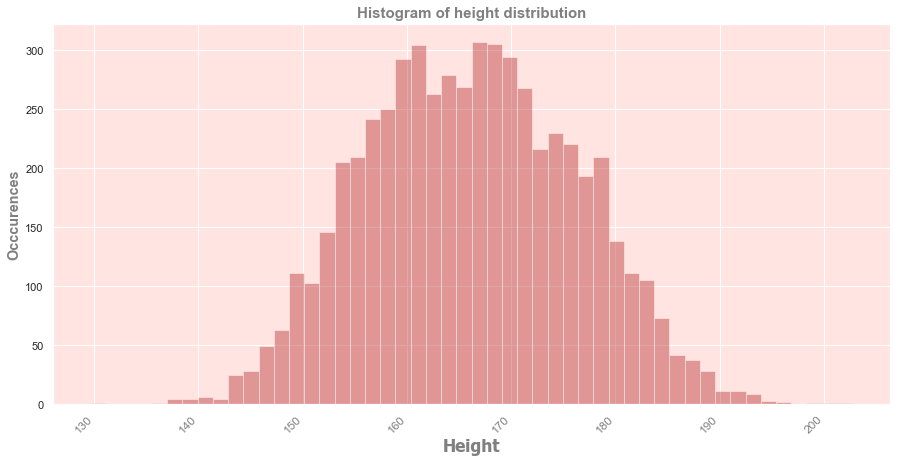

In [65]:
plt.figure(figsize= (15,7))
sns.set(rc={'axes.facecolor': 'mistyrose'})
sns.distplot(data.BMXHT, bins = 50, kde = False, color = 'firebrick', label = 'histogram')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium', color= 'grey')
plt.ylabel('Occcurences', fontweight = 'bold', fontsize = 'large', color= 'grey')
plt.xlabel('Height', fontweight = 'bold', fontsize = 'x-large', color= 'grey', fontfamily = "tahoma")
plt.title("Histogram of height distribution", weight="bold", fontsize=15, ha='center', color = 'grey')
plt.show()

When excessively large, the bars become so narrow that it was impossible to grasp the distribution. Medium-sized bar reveals that some heightes are more frequent than others an might be helpful to detect specific zones of concentration. Nevertheless it doesn't make sense to use a much bigger number than the range of the distribution. In this case, that would be 500 mm, or 500 bars.  
If small the graph does not allo the comprehension of the overall distribution and gaps that it has. It seems correct in this case to use 1 bar per 10 mm.

__Q3b.__ Make separate histograms for the heights of women and men, then make a side-by-side boxplot showing the heights of women and men.

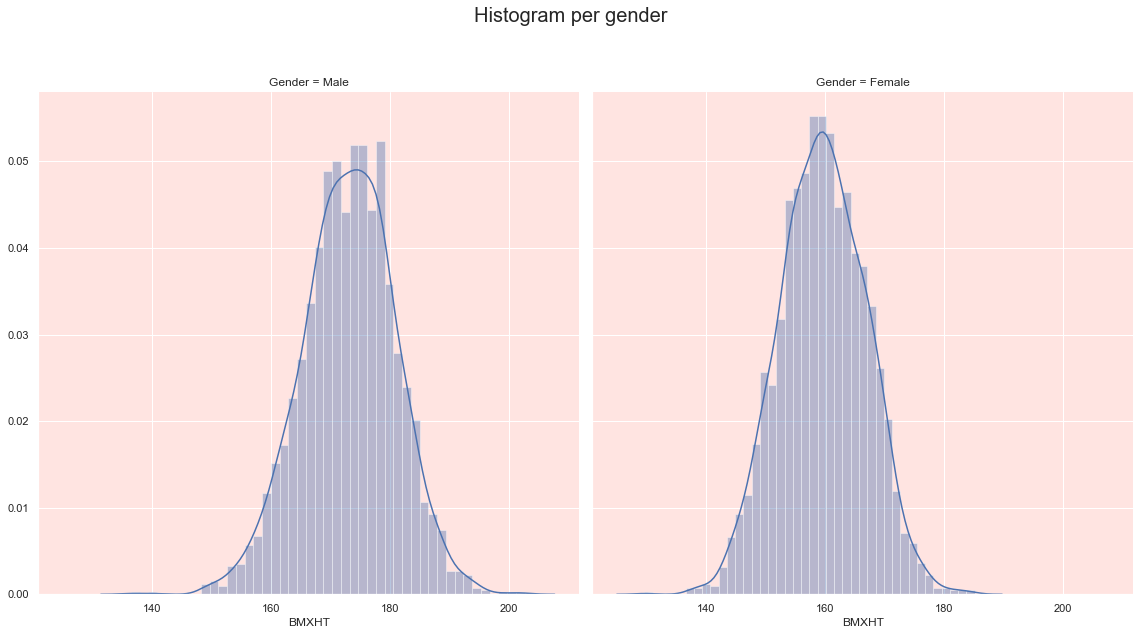

In [120]:
g = sns.FacetGrid(data, col = 'Gender', sharey = True,  height = 8)
g = g.map(sns.distplot, 'BMXHT', kde = True, norm_hist=True)
g.fig.suptitle('Histogram per gender', fontsize = 20, y= 1.1) # can also get the figure from plt.gcf()
plt.xlabel = ('Height')
plt.show(g)

Both distributions are bell shaped, but women's is more steep and therefore it has a lower standard deviation and range. Also, they don't have outliers. They can't be compared precisely if not normalized. In this case, it's better to look at the proportions an not frequency.

__Q3c.__ Comment on what features, if any are not represented clearly in the boxplots, and what features, if any, are easier to see in the boxplots than in the histograms.

The box plot in this case is not a good option. It does not show any difference between the faceted graphs. It would be better to use other characteristic to facet the data.

F:\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


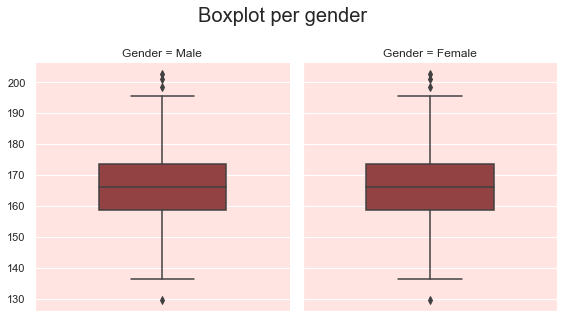

In [121]:
g = sns.FacetGrid(data, col = 'Gender',  height = 4)
g = g.map(sns.boxplot, y = 'BMXHT', color = 'firebrick', data = data, width = 0.5, saturation = 0.55)
#sns.boxplot()
g.fig.suptitle('Boxplot per gender', fontsize = 20, y= 1.1) 
plt.show(g)

## Question 4

Make a boxplot showing the distribution of within-subject differences between the first and second systolic blood pressure measurents ([BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1) and [BPXSY2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY2)).

Text(0.5, 1.1, 'Boxplot of systolic blood pressures per gender')

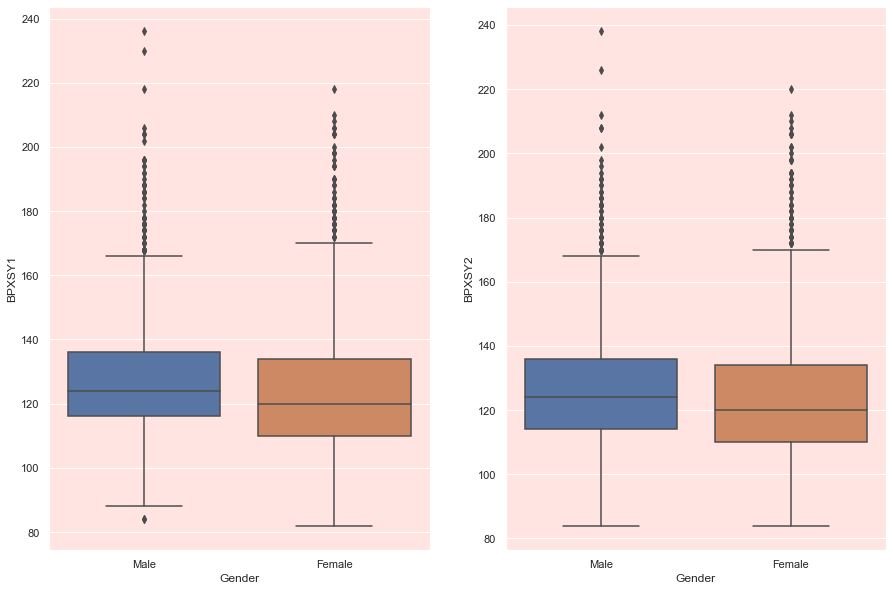

In [127]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,10))
sns.boxplot(y = 'BPXSY1', x = 'Gender', ax = ax1, data = data)
sns.boxplot(y = 'BPXSY2', x = 'Gender', ax = ax2, data = data)
fig.suptitle('Boxplot of systolic blood pressures per gender', fontsize = 20, y= 1.1) 


In [242]:
df4 = data.loc[:,['SEQN','Gender', 'BPXSY1', 'BPXSY2']].dropna()
df4['id'] = df4.index
df4

,SEQN,Gender,BPXSY1,BPXSY2,id
0,83732,Male,128.0,124.0,0
1,83733,Male,146.0,140.0,1
2,83734,Male,138.0,132.0,2
3,83735,Female,132.0,134.0,3
4,83736,Female,100.0,114.0,4
...,...,...,...,...,...
5730,93695,Female,112.0,112.0,5730
5731,93696,Male,118.0,116.0,5731
5732,93697,Female,154.0,146.0,5732
5733,93700,Male,104.0,106.0,5733


Wide to long pandas function! Good but not flexible. Columns you want to melt must begin with the same characters

In [281]:
df4b = pd.wide_to_long(df4, stubnames = 'BPXSY', i = 'id', j = 'SBPMeasure')
df4b

,,Gender,SEQN,BPXSY
id,SBPMeasure,,,
0,1,Male,83732,128.0
1,1,Male,83733,146.0
2,1,Male,83734,138.0
3,1,Female,83735,132.0
4,1,Female,83736,100.0
...,...,...,...,...
5730,2,Female,93695,112.0
5731,2,Male,93696,116.0
5732,2,Female,93697,146.0


__Q4a.__ What proportion of the subjects have a lower SBP on the second reading compared to the first?

In [259]:
100 * df4.loc[(df4.BPXSY1 > df4.BPXSY2)].shape[0] / df4.shape[0]

45.874464518532314

__Q4b.__ Make side-by-side boxplots of the two systolic blood pressure variables.


In [282]:
df4b.reset_index(inplace= True)
df4b = df4b.drop('id', axis = 1)

In [286]:
df4b['SBPMeasure'] = df4b['SBPMeasure'].replace({1 : "First Measure", 2 : "Second Measure"})

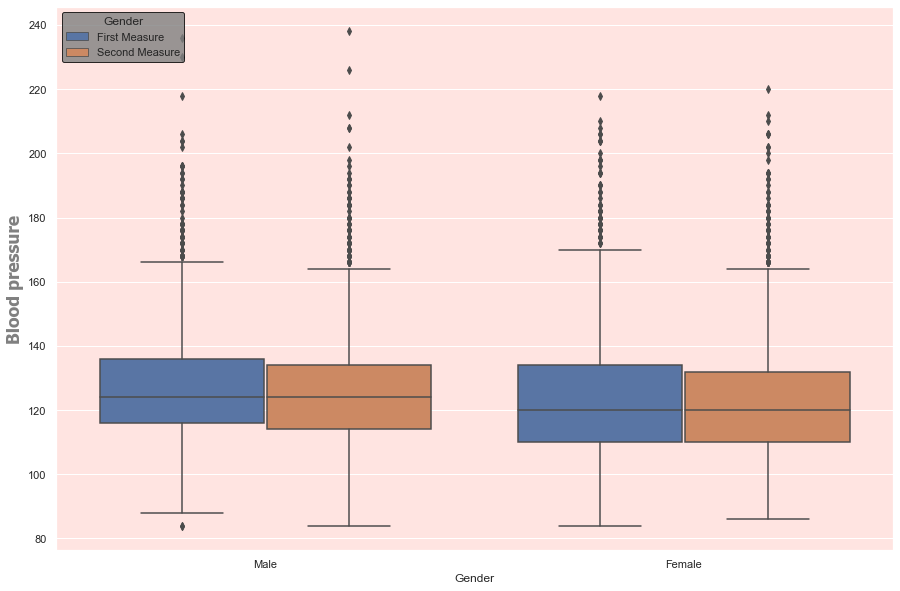

In [303]:
plt.figure(figsize=(15,10), edgecolor='white')
sns.boxplot(y = df4b.BPXSY,
           x = df4b.Gender,
           hue = df4b.SBPMeasure)
plt.legend(loc = 'upper left',
          edgecolor = 'black',
          facecolor = 'grey',
          title = 'Gender')
plt.ylabel('Blood pressure', fontweight = 'bold', fontsize = 'x-large',
           color= 'grey', fontfamily = "tahoma")

plt.show()


__Q4c.__ Comment on the variation within either the first or second systolic blood pressure measurements, and the variation in the within-subject differences between the first and second systolic blood pressure measurements.


## Question 5

Construct a frequency table of household sizes for people within each educational attainment category (the relevant variable is [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2)).  Convert the frequencies to proportions.


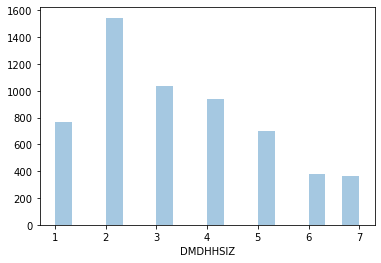

In [10]:
sns.distplot(data.DMDHHSIZ,kde = False, norm_hist= False)

In [293]:
df5 = data.rename (columns = {'DMDHHSIZ' : 'Household', 'DMDEDUC2' : 'EducationalAttainment' })
df5 = df5.loc[:,['Gender','Agex', 'Household', 'EducationalAttainment']]
df5 = df5.dropna()
df5.EducationalAttainment = df5.EducationalAttainment.apply(lambda x: int(x))
df5['EducationalAttainment'] = df5['EducationalAttainment'].replace({1 : 'Less than 9th grade',
                                                                    2 : '9-11th grade',
                                                                    3 : 'High school graduate/GED or equivalent',
                                                                    4 : 'Some college or AA degree',
                                                                    5 : 'College graduate or above',
                                                                    7 : 'Refused',
                                                                    9 : "Don't Know"})

In [294]:
df5.head()

,Gender,Agex,Household,EducationalAttainment
0,1,61 to 70,2,College graduate or above
1,1,51 to 60,1,High school graduate/GED or equivalent
2,1,71 to 80,2,High school graduate/GED or equivalent
3,2,51 to 60,1,College graduate or above
4,2,41 to 50,5,Some college or AA degree


In [309]:
df5a = pd.DataFrame(df5.groupby('EducationalAttainment')['Household'].value_counts())
df5a = df5a.rename(columns = {'Household' : 'Frequency'})

In [310]:
df5a.reset_index(inplace = True)

Best form to use lambda is to group first. This way the program reconizes the extension of the sum and I don't need to pass in any argument

In [312]:
df5a['Proportion'] = df5a.groupby('EducationalAttainment').Frequency.apply( lambda x : 100* x / x.sum())

In [313]:
df5a.groupby('EducationalAttainment').Proportion.sum()

EducationalAttainment
9-11th grade                              100.0
College graduate or above                 100.0
Don't Know                                100.0
High school graduate/GED or equivalent    100.0
Less than 9th grade                       100.0
Some college or AA degree                 100.0
Name: Proportion, dtype: float64

In [314]:
df5a = df5a.loc[~(df5a.EducationalAttainment == "Don't Know")]

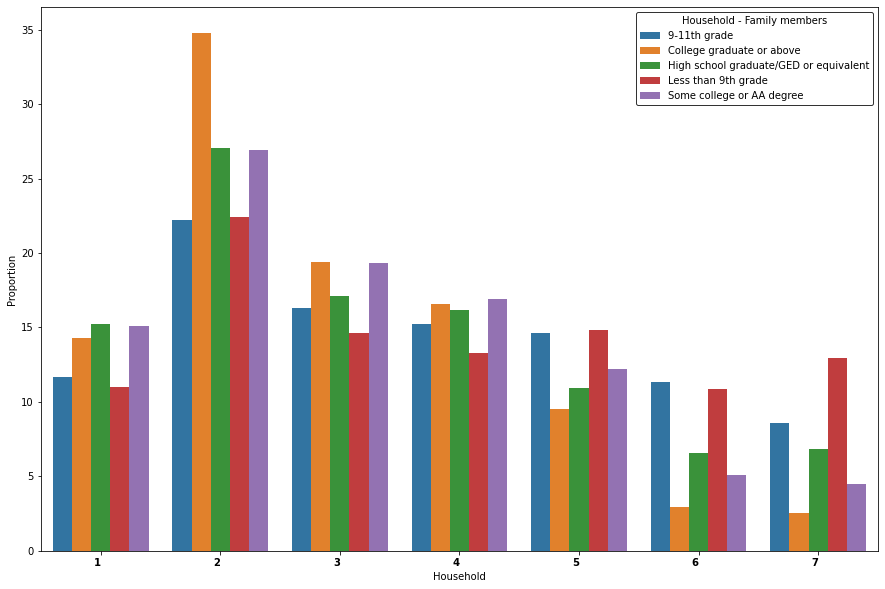

In [316]:
plt.figure (figsize = (15,10))
sns.barplot(x = 'Household', y = 'Proportion', hue = 'EducationalAttainment', data = df5a)
plt.xticks(horizontalalignment='right', fontweight='bold', fontsize='medium', color= 'black')
plt.legend( title = 'Household - Family members', edgecolor = 'black')
#plt.ylabel('Proportion', fontweight = 'bold', fontsize = 'large', color= 'grey')
#plt.xlabel = ('Educational Attainment', fontsize='Large', color= 'grey')

In [325]:
df5.Gender = df5.replace({1 : 'Male' , 2 : 'Female'})
df5c = df5.loc[df5.Agex == '31 to 40']
df5cA = pd.DataFrame(df5c.groupby(['EducationalAttainment','Gender']).Household.agg('median'))
df5cA.reset_index()


,EducationalAttainment,Gender,Household
0,9-11th grade,Female,5
1,9-11th grade,Male,5
2,College graduate or above,Female,4
3,College graduate or above,Male,3
4,High school graduate/GED or equivalent,Female,5
5,High school graduate/GED or equivalent,Male,4
6,Less than 9th grade,Female,5
7,Less than 9th grade,Male,5
8,Some college or AA degree,Female,4
9,Some college or AA degree,Male,4



__Q5a.__ Comment on any major differences among the distributions.


__Q5b.__ Restrict the sample to people between 30 and 40 years of age.  Then calculate the median household size for women and men within each level of educational attainment.


## Question 6

The participants can be clustered into "maked variance units" (MVU) based on every combination of the variables [SDMVSTRA](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#SDMVSTRA) and [SDMVPSU](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#SDMVPSU).  Calculate the mean age ([RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)), height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)), and BMI ([BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)) for each gender ([RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)), within each MVU, and report the ratio between the largest and smallest mean (e.g. for height) across the MVUs.

__Q6a.__ Comment on the extent to which mean age, height, and BMI vary among the MVUs.

In [8]:
data.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'Gender', 'Age',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'MaritalStatus', 'DMDHHSIZ',
       'WTINT2YR', 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1',
       'BPXSY2', 'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML',
       'BMXARMC', 'BMXWAIST', 'HIQ210'],
      dtype='object')

In [9]:
df6 = data[['SDMVPSU', 'SDMVSTRA', 'Gender', 'Age', 'BMXHT', 'BMXBMI']].dropna()

In [10]:
#clustering by groupby:
xmean = df6.groupby(['SDMVPSU', 'SDMVSTRA','Gender'])['Age', 'BMXHT', 'BMXBMI'].agg('mean')
xmean.head()

<ipython-input-10-01820d6acab3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  xmean = df6.groupby(['SDMVPSU', 'SDMVSTRA','Gender'])['Age', 'BMXHT', 'BMXBMI'].agg('mean')


Age       BMXHT     BMXBMI
SDMVPSU SDMVSTRA Gender                                  
1       119      Female  47.663265  159.570408  30.052041
                 Male    47.861111  172.741667  26.958333
        120      Female  43.887755  155.402041  32.419388
                 Male    43.030928  169.508247  30.939175
        121      Female  44.252632  158.871579  30.856842

#### Answer

In [11]:
xmean.describe().loc['min',:] / xmean.describe().loc['max',:]

Age       0.759525
BMXHT     0.878106
BMXBMI    0.780510
dtype: float64

__Q6b.__ Calculate the inter-quartile range (IQR) for age, height, and BMI for each gender and each MVU.  Report the ratio between the largest and smalles IQR across the MVUs.

In [13]:
df6grouped = df6.groupby(['SDMVPSU', 'SDMVSTRA', 'Gender'])['Age', 'BMXHT', 'BMXBMI']

<ipython-input-13-4d6c796e49c3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df6grouped = df6.groupby(['SDMVPSU', 'SDMVSTRA', 'Gender'])['Age', 'BMXHT', 'BMXBMI']


### IQR per gender

In [18]:
df6iqr = df6grouped.apply(lambda x : x.quantile(0.75) - x.quantile(0.25))
df6iqr = df6iqr.reset_index()

### Describe and loc :)

In [454]:
df6iqr.describe().loc['max'] - df6iqr.describe().loc['min']

Age       16.500
BMXHT      4.725
BMXBMI     7.650
dtype: float64

__Q6c.__ Comment on the extent to which the IQR for age, height, and BMI vary among the MVUs.

In [23]:
df6iqr.loc[(df6iqr.SDMVSTRA == 119)]

,SDMVPSU,SDMVSTRA,Gender,Age,BMXHT,BMXBMI
0,1,119,Female,31.25,9.325,9.75
1,1,119,Male,29.75,9.000,5.35
30,2,119,Female,33.50,9.950,9.35
31,2,119,Male,30.00,11.150,5.30


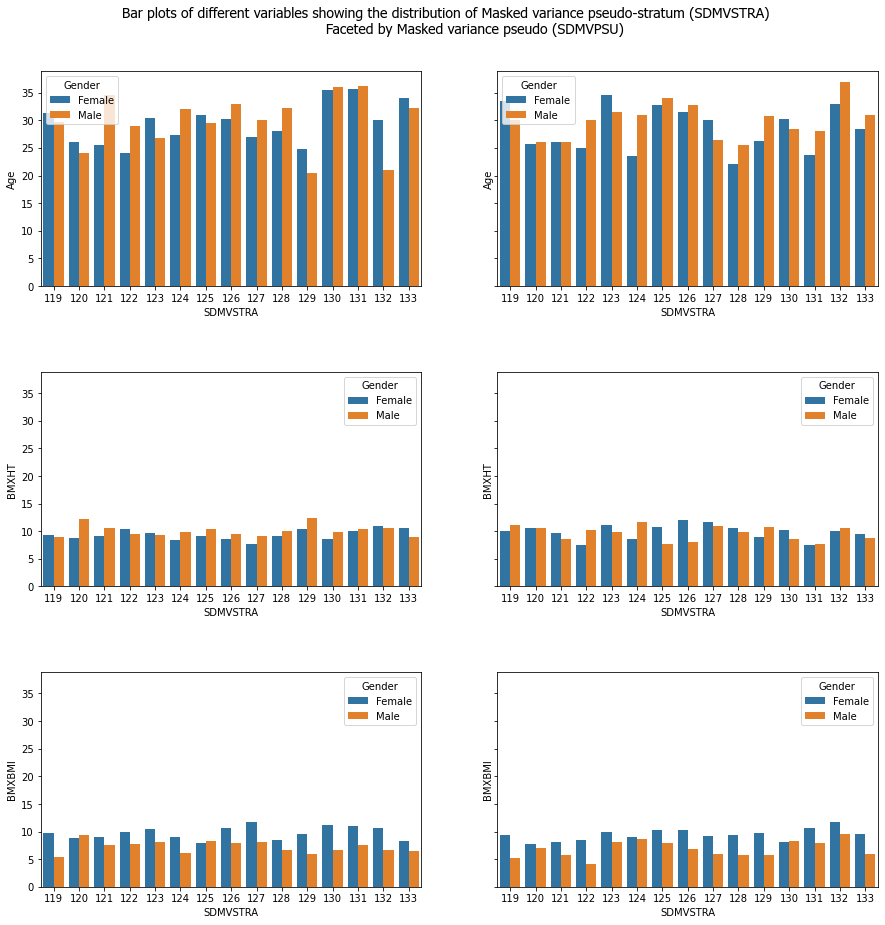

In [83]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize = (15,15), sharey = True, squeeze= False)
df6iqrplot1 = df6iqr.loc[(df6iqr.SDMVPSU == 1)]
df6iqrplot2 = df6iqr.loc[(df6iqr.SDMVPSU == 2)]

bage1 = sns.barplot(x = 'SDMVSTRA', y = 'Age', hue = 'Gender', ax = ax1, data = df6iqrplot1)
bage2 = sns.barplot(x = 'SDMVSTRA', y = 'Age', hue = 'Gender', ax = ax2, data = df6iqrplot2)
bheight1 = sns.barplot(x = 'SDMVSTRA', y = 'BMXHT', hue = 'Gender', ax = ax3, data = df6iqrplot1)
bheight2 = sns.barplot(x = 'SDMVSTRA', y = 'BMXHT', hue = 'Gender', ax = ax4, data = df6iqrplot2)
bBMI1 = sns.barplot(x = 'SDMVSTRA', y = 'BMXBMI', hue = 'Gender', ax = ax5, data = df6iqrplot1)
bBMI2 = sns.barplot(x = 'SDMVSTRA', y = 'BMXBMI', hue = 'Gender', ax = ax6, data = df6iqrplot2)

plt.subplots_adjust(hspace = 0.4, wspace = 0.2)

fig.suptitle('''Bar plots of different variables showing the distribution of Masked variance pseudo-stratum (SDMVSTRA)
             Faceted by Masked variance pseudo (SDMVPSU)''', y = 0.94, fontsize = 14, fontfamily = 'tahoma')

#plt.text(7, 15, s = "Teste")
#plt.tight_layout(pad = 5.0)
plt.show()

In [14]:
data.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'Gender', 'Age',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'MaritalStatus', 'DMDHHSIZ',
       'WTINT2YR', 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1',
       'BPXSY2', 'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML',
       'BMXARMC', 'BMXWAIST', 'HIQ210'],
      dtype='object')

In [24]:
q1 = data.BPXSY2.dropna().agg('median')
q1

122.0

In [29]:
q2 = data.BPXSY2.dropna().agg('mean')
round(q2, 1)

124.8

In [30]:
q3 = data.BPXSY2.dropna().agg('std')
round(q3, 1)

18.5

In [31]:
q4 = data.BPXSY2.dropna().agg('max')
round(q4, 1)

238.0

In [33]:
q5 = data.BPXSY2.dropna()
q5 = np.percentile(q5, 75) - np.percentile(q5, 25)
round(q5, 1)

22.0

In [50]:
data.groupby('DMDEDUC2').Gender.value_counts().unstack()

Gender,Female,Male
DMDEDUC2,,
1.0,349,306
2.0,291,352
3.0,583,603
4.0,909,712
5.0,717,649
9.0,1,2
